# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [ ]:
# Plan is to use correlation techniques to see what features are coreelated to the price of the car.

In [ ]:
# Secondly we will use regression models to predict the price of the car with the available features and inturn discover that what features are influencing the price more than others

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [201]:
# Import libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from random import shuffle, seed
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [149]:
# Load Dataset
vehicles_df = pd.read_csv('data/vehicles.csv')

In [150]:
# View Column Data Count 
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [151]:
# View NaN data count
print(vehicles_df.isna().sum())

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [152]:
# Fill Missing Values with Zeroes
for col in ['cylinders', 'condition', 'drive', 'paint_color', 'type', 'manufacturer']:
    vehicles_df[col]=vehicles_df[col].fillna(vehicles_df[col].mode()[0])

In [153]:
# Drop irrevalent columns (id, vin , region, state )(size excessive Nan )
vehicles_df.drop(columns=['id', 'VIN', 'region', 'state','size','model','transmission','title_status'], inplace=True)

In [154]:
vehicles_df.dropna(subset=['price', 'year', 'odometer','fuel'], inplace=True)

In [155]:
vehicles_df = vehicles_df[vehicles_df['price'] != 0]
vehicles_df.shape

(388459, 10)

In [156]:
# View NaN data count
print(vehicles_df.isna().sum())

price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
drive           0
type            0
paint_color     0
dtype: int64


In [157]:
# Applying one-hot encoding on the categorical columns
v_df_e = pd.get_dummies(vehicles_df, columns=[
    'manufacturer', 'condition', 'cylinders', 'fuel', 'drive', 'type', 'paint_color'], 
    drop_first=True)

In [158]:
v_df_e.info()

<class 'pandas.core.frame.DataFrame'>
Index: 388459 entries, 27 to 426879
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   price                         388459 non-null  int64  
 1   year                          388459 non-null  float64
 2   odometer                      388459 non-null  float64
 3   manufacturer_alfa-romeo       388459 non-null  bool   
 4   manufacturer_aston-martin     388459 non-null  bool   
 5   manufacturer_audi             388459 non-null  bool   
 6   manufacturer_bmw              388459 non-null  bool   
 7   manufacturer_buick            388459 non-null  bool   
 8   manufacturer_cadillac         388459 non-null  bool   
 9   manufacturer_chevrolet        388459 non-null  bool   
 10  manufacturer_chrysler         388459 non-null  bool   
 11  manufacturer_datsun           388459 non-null  bool   
 12  manufacturer_dodge            388459 non-null  b

In [159]:
#**We will use the z-score from the stats module, to calculate the z-score of the `price` column. We would take an absolute of those values and throw out any value greater than 3.**
v_df_ez = v_df_e[np.abs(stats.zscore(v_df_e['price'])) < 3].copy()

In [160]:
# IQR Treatment

numerical_cols = ['price', 'year', 'odometer']
Q1 = v_df_ez[numerical_cols].quantile(0.25)
Q3 = v_df_ez[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
# Remove outliers
v_df = v_df_ez[~((v_df_ez[numerical_cols] < (Q1 - 1.5 * IQR)) | 
                              (v_df_ez[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

v_df.shape

(362634, 85)

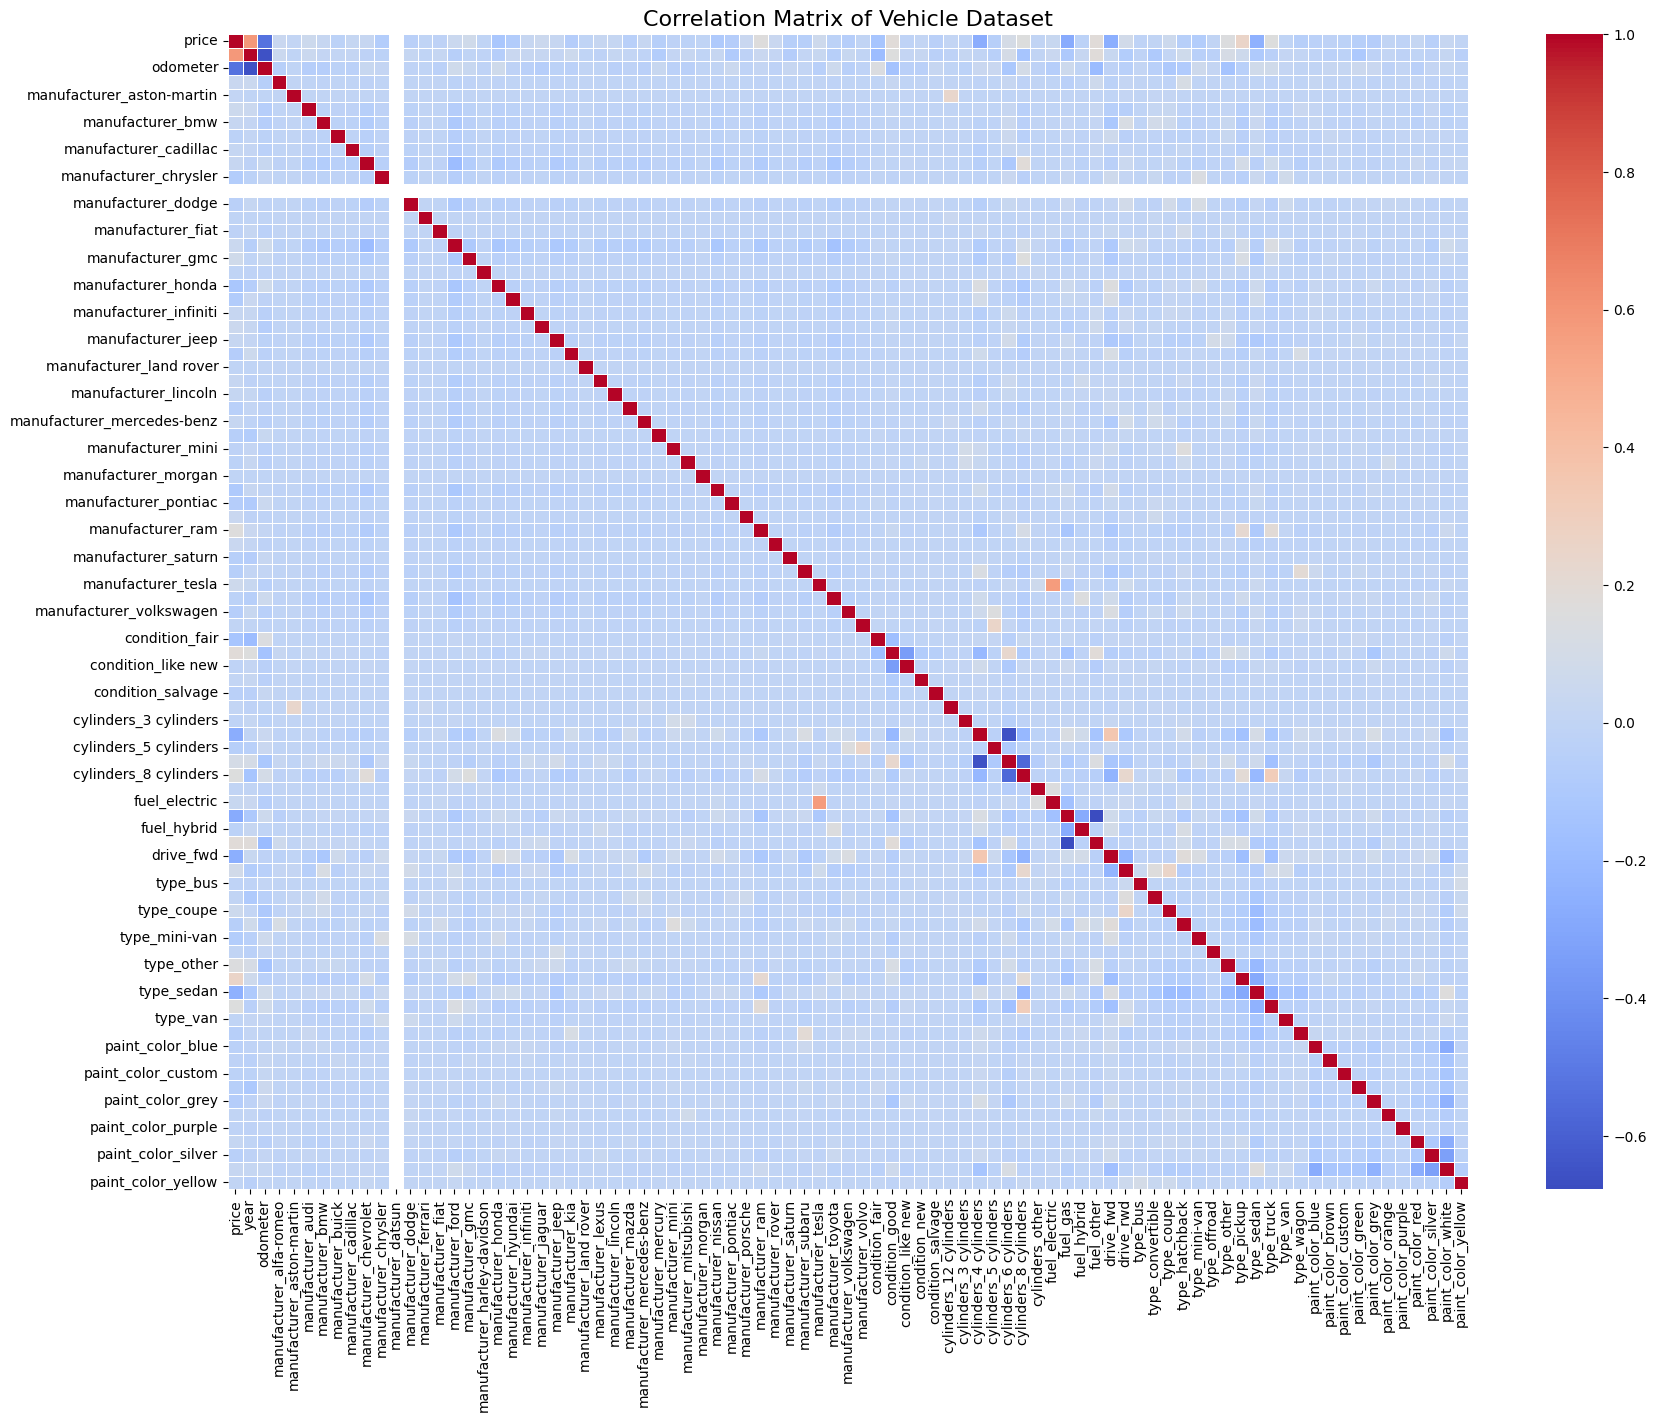

In [161]:
# Calculate the correlation matrix
correlation_matrix = v_df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Vehicle Dataset", fontsize=16)
plt.show()

In [162]:
# Correlation of features with price
price_correlation = correlation_matrix['price'].sort_values(ascending=False)

price_correlation = price_correlation[1:]  # Exclude price itself

# Show top impacting variables (positive and negative)
price_correlation_sorted = price_correlation.sort_values(key=abs, ascending=False).head(10)
price_correlation_sorted 
#=============================================
# see analysis in the evaluation section

year                     0.585865
odometer                -0.529649
fuel_gas                -0.279054
cylinders_4 cylinders   -0.264801
drive_fwd               -0.258467
type_pickup              0.254752
type_sedan              -0.248734
condition_good           0.186229
fuel_other               0.185953
manufacturer_ram         0.166500
Name: price, dtype: float64

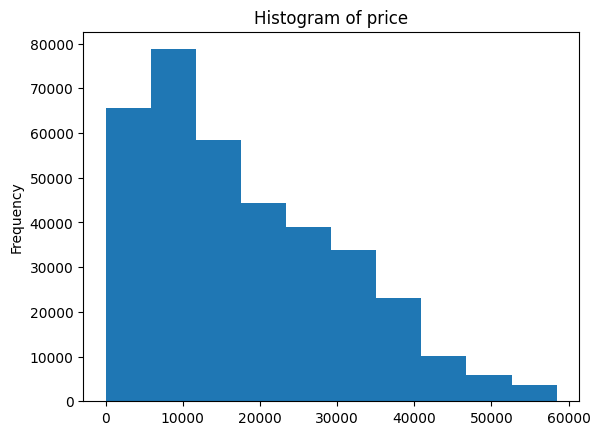

In [163]:
v_df['price'].plot(kind = 'hist', title = "Histogram of price");


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [164]:
# Splitting the data into features (X) and target (y)
X = v_df.drop(columns=['price'])
y = v_df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting Ridge regression to identify feature importance
ridge_model = Ridge(alpha=0.3)
lasso_model = Lasso()
linear_model = LinearRegression()

In [165]:
linear_model.fit(X_train, y_train)

LinearRegression()

In [166]:
lasso_model.fit(X_train, y_train)

Lasso()

In [167]:


ridge_model.fit(X_train, y_train)

Ridge(alpha=0.3)

In [168]:
linear_preds = linear_model.predict(X_test)
lasso_preds = lasso_model.predict(X_test)
ridge_preds = ridge_model.predict(X_test)

In [169]:
# Calculate RMSE for each model
linear_rmse = np.sqrt(root_mean_squared_error(y_test, linear_preds))
lasso_rmse = np.sqrt(root_mean_squared_error(y_test, lasso_preds))
ridge_rmse = np.sqrt(root_mean_squared_error(y_test, ridge_preds))

In [170]:
# Display RMSE results
{
    "Linear Regression RMSE": linear_rmse,
    "Lasso RMSE": lasso_rmse,
    "Ridge RMSE": ridge_rmse
}

{'Linear Regression RMSE': 87.87519021001461,
 'Lasso RMSE': 87.89770706320616,
 'Ridge RMSE': 87.87581951857689}

In [171]:
# Extract feature names and coefficients from the Ridge model
ridge_coefficients = pd.Series(ridge_model.coef_, index=X_train.columns)

# Sort coefficients by magnitude (absolute value) to identify most impactful features
ridge_feature_importance = ridge_coefficients.sort_values(key=abs, ascending=False)

# Display the top features impacting price (both positively and negatively)
ridge_feature_importance.head(10)


fuel_electric                  -14464.799670
fuel_hybrid                    -13345.318037
fuel_gas                       -12541.053641
manufacturer_tesla              12477.994961
manufacturer_ferrari           -11871.660125
fuel_other                     -11157.940246
manufacturer_porsche             8685.117720
manufacturer_fiat               -8532.147395
cylinders_3 cylinders           -7595.014310
manufacturer_harley-davidson    -7339.331894
dtype: float64

In [172]:
# Extract feature names and coefficients from the Lasso model
lasso_coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)

# Sort coefficients by magnitude (absolute value) to identify most impactful features
lasso_feature_importance = lasso_coefficients.sort_values(key=abs, ascending=False)

# Display the top features impacting price (both positively and negatively)
lasso_feature_importance.head(10)

fuel_electric             -13798.584629
fuel_hybrid               -13150.692852
fuel_gas                  -12450.352359
manufacturer_tesla         11892.029592
fuel_other                -11030.886111
manufacturer_porsche        8747.857722
manufacturer_fiat          -7636.381097
manufacturer_mitsubishi    -6055.316141
cylinders_3 cylinders      -6017.261804
manufacturer_kia           -5526.565322
dtype: float64

In [173]:
# Extract feature names and coefficients from the Linear model
linear_coefficients = pd.Series(linear_model.coef_, index=X_train.columns)

# Sort coefficients by magnitude (absolute value) to identify most impactful features
linear_feature_importance = linear_coefficients.sort_values(key=abs, ascending=False)

# Display the top features impacting price (both positively and negatively)
linear_feature_importance.head(10)

fuel_electric                  -14475.039208
fuel_hybrid                    -13347.844531
manufacturer_ferrari           -13079.399255
fuel_gas                       -12542.287760
manufacturer_tesla              12487.139795
fuel_other                     -11159.458168
manufacturer_porsche             8683.640768
manufacturer_fiat               -8541.006495
cylinders_3 cylinders           -7605.192924
manufacturer_harley-davidson    -7365.142908
dtype: float64

In [178]:
# Enhanced Modeling - Trying Multiple Alphas

In [203]:
alphas = [0.001, 1.0, 10.0, 100.0,1000.0]

# Ridge Regression with manual alpha tuning


best_alpha, min_loss, coef_list = None, float('inf'), []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    ridge_preds = ridge.predict(X_test)  # Predict on the test set
    rmse_loss_val = np.sqrt(mean_squared_error(y_test, ridge_preds))  # Calculate RMSE
    if rmse_loss_val < min_loss:
        best_alpha = alpha
        min_loss = rmse_loss_val
        coef_list = list(ridge.coef_)

# Create a DataFrame of coefficients and corresponding feature names
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": coef_list
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Display the best alpha and top features
best_alpha, min_loss, coef_df.head(100)

C:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.33166e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


(0.001,
 7722.049456187661,
                        Feature   Coefficient
 55               fuel_electric -14475.005057
 57                 fuel_hybrid -13347.836116
 12        manufacturer_ferrari -13074.969473
 56                    fuel_gas -12542.283642
 39          manufacturer_tesla  12487.109906
 ..                         ...           ...
 7        manufacturer_cadillac   -127.326489
 27  manufacturer_mercedes-benz    -32.843552
 65               type_mini-van     -7.053635
 1                     odometer     -0.055597
 10         manufacturer_datsun      0.000000
 
 [84 rows x 2 columns])

In [ ]:
# Advanced Modeling - Using PCA

In [209]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [210]:
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [211]:
# Fit Ridge Regression on PCA-transformed data
ridge_pca = Ridge(alpha=1.0)
ridge_pca.fit(X_train_pca, y_train)

# Evaluate the model
ridge_preds = ridge_pca.predict(X_test_pca)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_preds))
print(ridge_rmse)

8215.472475956005


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [176]:
## potential conclusions from corelation matrix
# Price and Odometer: negative correlation, it suggests that vehicles with higher odometer readings (more miles) lead to have lower prices.
# Year and Price: A positive correlation indicates that newer vehicles generally have higher prices.
# Year and Odometer: weak or inverse correlation, newer vehicles tend to have lower mileage.


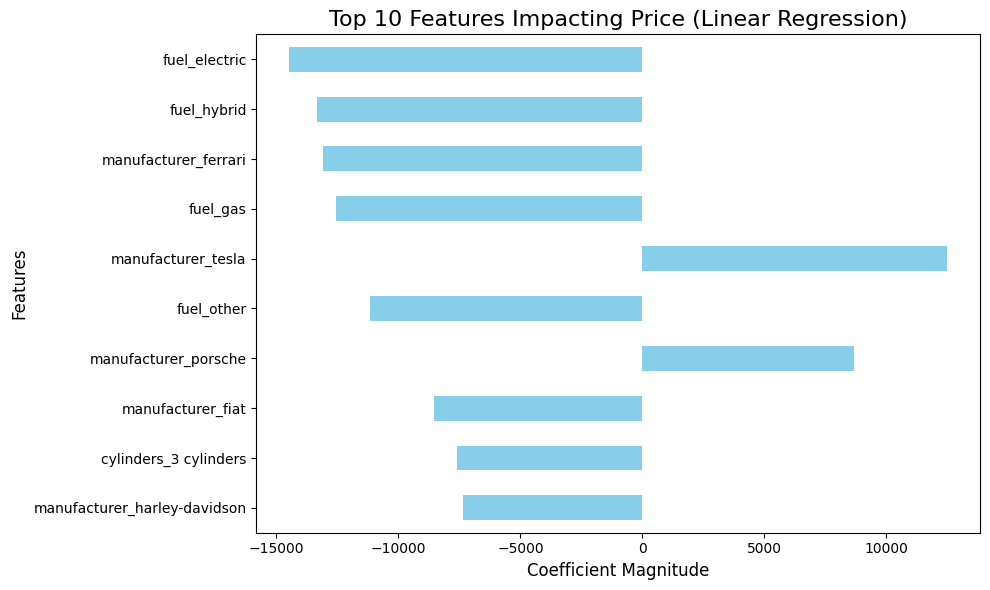

In [146]:
# Select top 10 most impactful features based on Linear regression coefficients
top_features = linear_feature_importance.head(10)

# Plot the top features
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='skyblue')
plt.title('Top 10 Features Impacting Price (Linear Regression)', fontsize=16)
plt.xlabel('Coefficient Magnitude', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to display the most impactful at the top
plt.tight_layout()
plt.show()

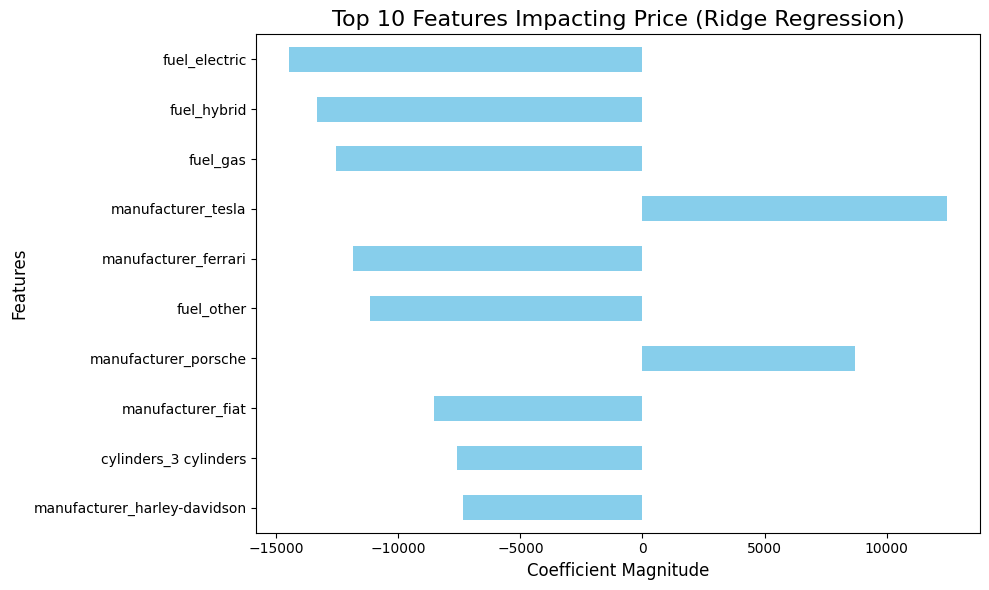

In [147]:
# Select top 10 most impactful features based on Ridge regression coefficients
top_features = ridge_feature_importance.head(10)

# Plot the top features
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='skyblue')
plt.title('Top 10 Features Impacting Price (Ridge Regression)', fontsize=16)
plt.xlabel('Coefficient Magnitude', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to display the most impactful at the top
plt.tight_layout()
plt.show()

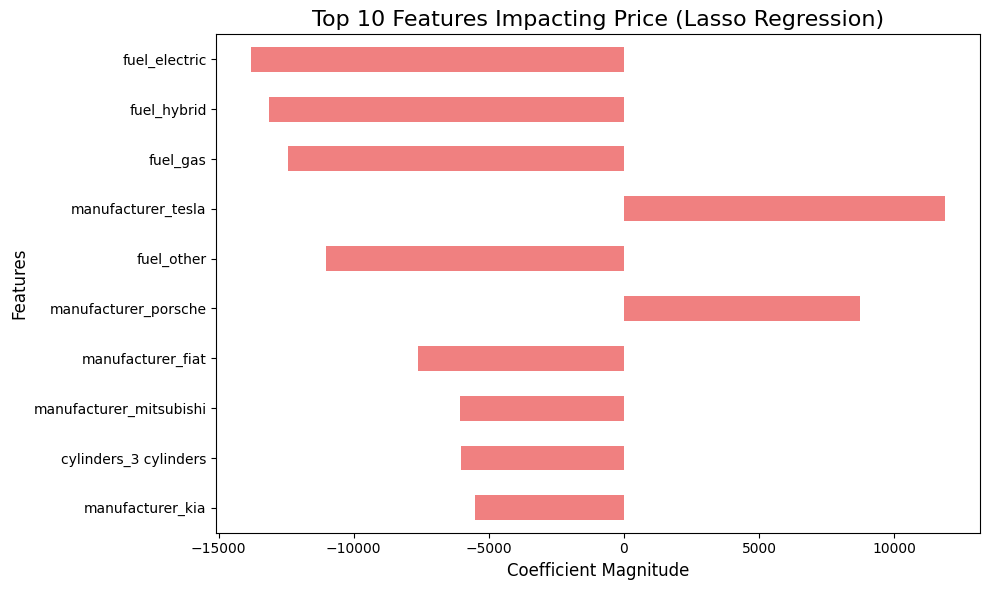

In [137]:
# Extract feature importance from Lasso model
lasso_coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)

# Select top 10 most impactful features based on Lasso regression coefficients
top_lasso_features = lasso_coefficients.sort_values(key=abs, ascending=False).head(10)

# Plot the top features
plt.figure(figsize=(10, 6))
top_lasso_features.plot(kind='barh', color='lightcoral')
plt.title('Top 10 Features Impacting Price (Lasso Regression)', fontsize=16)
plt.xlabel('Coefficient Magnitude', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to display the most impactful at the top
plt.tight_layout()
plt.show()


Analysis
=========
fuel_electric	-	Electric fuel type negatively impacts price significantly.
manufacturer_tesla	- Tesla as a manufacturer has a strong positive influence on price.
fuel_hybrid	- 	Hybrid fuel type also negatively impacts price but slightly less than electric.
fuel_gas	-	Gasoline-powered vehicles have a noticeable negative impact on price.
cylinders_12	-	Vehicles with 12 cylinders strongly increase the price, likely reflecting high performance.
manufacturer_porsche	-	Porsche vehicles contribute significantly to a higher price.
manufacturer_fiat	-6504.56	Fiat as a manufacturer lowers the price.
cylinders_3	-	Vehicles with 3 cylinders strongly decrease the price, likely reflecting low performance.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.